In [1]:
# Run these lines only the first time you run this notebook

# !pip install tensorflow_addons gdown shap -q
# !pip install git+https://github.com/katarinagresova/DeepExperiment

# !wget https://github.com/ML-Bioinfo-CEITEC/miRBind/raw/main/Models/miRBind.h5
# !wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRBind/graphs/Datasets/evaluation_set_1_1_CLASH2013_paper.tsv

In [2]:
# import tensorflow

In [3]:
# tensorflow.__version__

In [4]:
from pytorch_lightning.loggers import CometLogger

### Load and preprocess the transcript data

In [5]:
from Bio import SeqIO
import re

def extract_gene_symbol(record):
    tmp = [re.findall("\((.*?)\)", x) for x in record.description.split()]
    while([] in tmp):
        tmp.remove([])
    return tmp[0][0]

gene_symbol_to_seq = {}
file_path = 'data/GCF_000001405.40/rna.fna'

for record in SeqIO.parse(file_path, "fasta"):
    description = record.description.split()
    gene_id = next((item.split('=')[1] for item in description if item.startswith('gene=')), None)
    
    symbol = extract_gene_symbol(record)
    # Do not need the locus tag (== record.id) for now
    # gene_symbol_to_seq[symbol] = [record.seq, record.id]
    gene_symbol_to_seq[symbol] = record.seq    

In [6]:
len(gene_symbol_to_seq.items())

42423

### Get our deep learning model and miRNA data

In [7]:
import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.utils import register_keras_serializable
# import tensorflow_addons as tfa
# import cv2 
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from textwrap import wrap
import random
# import shap
# from shap.plots.colors import red_transparent_blue

# from deepexperiment.alignment import Attrament
# from deepexperiment.visualization import plot_alignment, plot_miRNA_importance, plotbar_miRNA_importance
# from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch
# from deepexperiment.interpret import DeepShap

In [8]:
random.seed(42)

In [9]:
# """# Loading model and the data"""

# model = keras.models.load_model("miRBind.h5")
# # model.summary()

samples = pd.read_csv('evaluation_set_1_1_CLASH2013_paper.tsv', sep='\t')
samples.head()

# # get the miRNAs
# #     CHANGE choose the miRNA
# # miRNA = samples['miRNA'].value_counts().index[6]
# # miRNA

,miRNA,gene,label
0,TAGGTAGTTTCATGTTGTTG,AGACCAGCAACAAACTACCAACACTGTAGAGGAGCCCCTGGATCTT...,1
1,GCAGTCCATGGGCATATACA,CAGCCAAGCCCAGGCTCGCAGTATCAATAAAGCAGTTCTCTGAGGA...,1
2,CAAAGTGCTTACAGTGCAGG,TGAGAACACTTAAAGTTCAAATAGAAATCATTTCTGAAGACAAAAG...,1
3,GAGGGTTGGGTGGAGGCTCT,AATGCCCCAAAATCCAAACCTTCCTGAACGCTATGACACCATGAGT...,1
4,ACTGCCCTAAGTGCTCCTTC,AAGAAACTAGGAGAATGGGTAGGCCTTTGTAAAATTGACAGAGAGG...,1


### Get the scores for FC comparison using files from Bartel  

In [10]:
mirna_FCs = pd.read_csv('modules/evaluation/mirna_fcs.csv',index_col=0, header=0, sep=',')

In [11]:
# mirna_FCs
mirna_FCs['Gene symbol']

RefSeq ID
NM_000017       ACADS
NM_000019       ACAT1
NM_000021       PSEN1
NM_000023        SGCA
NM_000027         AGA
               ...   
NM_213646        WARS
NM_213647       FGFR4
NM_213649       SFXN4
NM_213651    SLC25A24
NM_213662       STAT3
Name: Gene symbol, Length: 8372, dtype: object

In [12]:
def rna_to_dna(rna_sample):
    rna_dic = {
        'A':'A',
        'C':'C',
        'U':'T',
        'G':'G',
    }
    converted = [rna_dic[x.upper()] for x in rna_sample]
    new = ""
    # traverse in the string
    for x in converted:
        new += x
    # return string
    return new

In [13]:
mirna_sequences = ['UAGCAGCACGUAAAUAUUGGCG', 'UAAAGUGCUGACAGUGCAGAU', 'UAACACUGUCUGGUAACGAUGU', 'UAAUACUGCCUGGUAAUGAUGA', 'AUGACCUAUGAAUUGACAGAC', 'UGAGGUAGUAGGUUGUAUGGUU', 'AGCAGCAUUGUACAGGGCUAUGA']
mirna_sequences = [rna_to_dna(x) for x in mirna_sequences]
print(mirna_sequences)

['TAGCAGCACGTAAATATTGGCG', 'TAAAGTGCTGACAGTGCAGAT', 'TAACACTGTCTGGTAACGATGT', 'TAATACTGCCTGGTAATGATGA', 'ATGACCTATGAATTGACAGAC', 'TGAGGTAGTAGGTTGTATGGTT', 'AGCAGCATTGTACAGGGCTATGA']


In [14]:
miRNA_names = ['hsa-miR-16-5p', 'hsa-miR-106b-5p', 'hsa-miR-200a-3p', 'hsa-miR-200b-3p', 'hsa-miR-215-5p', 'hsa-let-7c-5p', 'hsa-miR-103a-3p']
miRNA_name_to_seq = {}
for i in range(len(miRNA_names)):
    miRNA_name_to_seq[miRNA_names[i]] = mirna_sequences[i]
miRNA_name_to_seq

{'hsa-miR-16-5p': 'TAGCAGCACGTAAATATTGGCG',
 'hsa-miR-106b-5p': 'TAAAGTGCTGACAGTGCAGAT',
 'hsa-miR-200a-3p': 'TAACACTGTCTGGTAACGATGT',
 'hsa-miR-200b-3p': 'TAATACTGCCTGGTAATGATGA',
 'hsa-miR-215-5p': 'ATGACCTATGAATTGACAGAC',
 'hsa-let-7c-5p': 'TGAGGTAGTAGGTTGTATGGTT',
 'hsa-miR-103a-3p': 'AGCAGCATTGTACAGGGCTATGA'}

#### Only for 1 miRNA now 

In [15]:
mirna_sequences = ['TAAAGTGCTGACAGTGCAGAT']
mirna_sequences
mirna_name = 'hsa-miR-106b-5p'
# mirna_name = 'hsa-miR-16-5p'
my_miRNA = 'TAAAGTGCTGACAGTGCAGAT'
# my_miRNA = 'TAGCAGCACGTAAATATTGGCG'

In [16]:
gene_symbols = mirna_FCs[mirna_FCs[mirna_name].isnull() == False]['Gene symbol'].values
print(len(gene_symbols))

8092


### Collect binding sites

#### Load the explainability scoring

In [17]:
import json

load_scores_path = "explainability_scores_{}.json".format(mirna_name)

with open(load_scores_path, 'r') as file:
    miRNA_to_gene_score_loaded = json.load(file)

In [18]:
print(type(miRNA_to_gene_score_loaded), type(miRNA_to_gene_score_loaded[my_miRNA]))

<class 'dict'> <class 'list'>


In [19]:
print(
    miRNA_to_gene_score_loaded[my_miRNA][0][0], 
    len(miRNA_to_gene_score_loaded[my_miRNA][0][1])
)

A2M 4953


In [20]:
# loaded_genes = [x[0] for x in miRNA_to_gene_score_loaded[my_miRNA]]

In [21]:
def get_islands(arr):
    # Find start and end+1 of each island
    starts = np.array([], int)
    ends = np.array([], int)
    for i in range(len(arr)-1):        
        if arr[i] == 0 and arr[i+1] != 0 or i==0 and arr[i] != 0:
            # starts.append(i+1)
            starts = np.append(starts, i+1)
        if arr[i] != 0 and arr[i+1] == 0:
            # or arr[i] != 0 and len(arr) == i
            # ends.append(i)
            ends = np.append(ends, i+1)

    # Get lengths of each island
    lengths = ends - starts

    # Return as pairs of (start, length)
    # return list(zip(starts, ends, lengths))
    return (starts, ends, lengths)

idxes = [] 
for i in [1, 6, 19]:
    idxes.append(get_islands(miRNA_to_gene_score_loaded[my_miRNA][i][1]))
    

In [22]:
print(miRNA_to_gene_score_loaded[my_miRNA][19][1][idxes[2][0][0]-1 : idxes[2][1][0]+1])

[0.0, 6.660619284957647e-05, 9.951850399374961e-05, 0.0003023144789040089, 0.00014385688118636608, 0.00025316121056675914, 0.0002203066274523735, 0.0021231752634048463, 0.0026548716425895693, 0.0004114201292395592, 0.0006678072363138199, 0.001579331474031278, 0.0008955527911894024, 0.001183917294256389, 0.001704848101362586, 0.0010069606266915798, 0.002865324360318482, 0.0012442029174417257, 0.0008290026636677794, 0.0015094609186053277, 0.00041354633285664024, 0.0015391211956739426, 0.0017147809267044067, 0.00025641327840276063, 0.0001803998585091904, 9.855834767222405e-05, 9.49101964943111e-05, 0.00012953354278579353, 4.004052258096635e-05, 8.373179472982884e-05, 6.380955455824733e-05, 4.151891625951976e-05, 9.057046379894018e-05, 6.791138206608593e-05, 7.710815290920436e-05, 0.00010695577890146524, 4.696741001680493e-05, 9.77395661175251e-05, 4.539894638583064e-05, 5.431550554931164e-05, 3.226074069971219e-05, 5.066958954557777e-05, 4.7975672059692444e-05, 6.335656566079706e-05, 3.13

In [23]:
#starts
for k in idxes[2][0]:
    print(miRNA_to_gene_score_loaded[my_miRNA][19][1][k])
    
#ends
for k in idxes[2][1]:
    print(miRNA_to_gene_score_loaded[my_miRNA][19][1][k-1])

6.660619284957647e-05
1.878536073490977e-05
1.2466057669371366e-05
8.602754678577185e-07
1.037647743942216e-06
7.927888509584591e-07


In [24]:
binding_sites = []

for scores in miRNA_to_gene_score_loaded[my_miRNA]:
    binding_sites.append(get_islands(scores[1]))

len(binding_sites)

42402

In [25]:
len(miRNA_to_gene_score_loaded[my_miRNA])

42402

In [26]:
binding_sites[22]

(array([ 2020,  2230,  2530,  2930,  3940,  4410,  8700, 10160, 10740]),
 array([ 2080,  2330,  2600,  2980,  3990,  4460,  8750, 10230, 10800]),
 array([ 60, 100,  70,  50,  50,  50,  50,  70,  60]))

<BarContainer object of 600 artists>

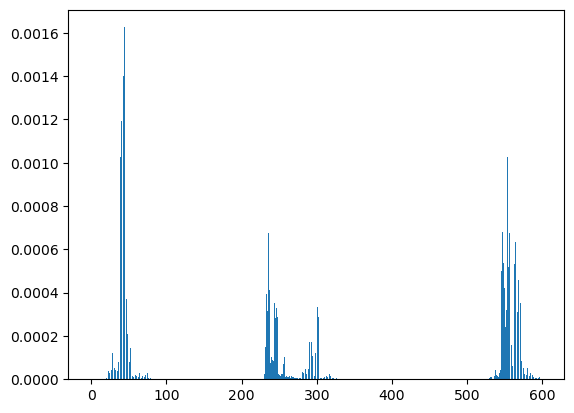

In [27]:
import matplotlib.pyplot as plt

tmp = miRNA_to_gene_score_loaded[my_miRNA][22][1][2000:2600]
plt.bar(range(len(tmp)), tmp)

OrderedDict([(49, 231), (50, 38148), (59, 98), (60, 25235), (69, 18), (70, 4816), (79, 2), (80, 500), (89, 2), (90, 476), (99, 5), (100, 506), (110, 338), (119, 2), (120, 161), (130, 48), (140, 16), (150, 8), (160, 9), (170, 1), (180, 5), (190, 3), (200, 2), (210, 1), (260, 1), (420, 1), (430, 1), (650, 1)])


Text(0.5, 1.0, "Islands' lengths per genes")

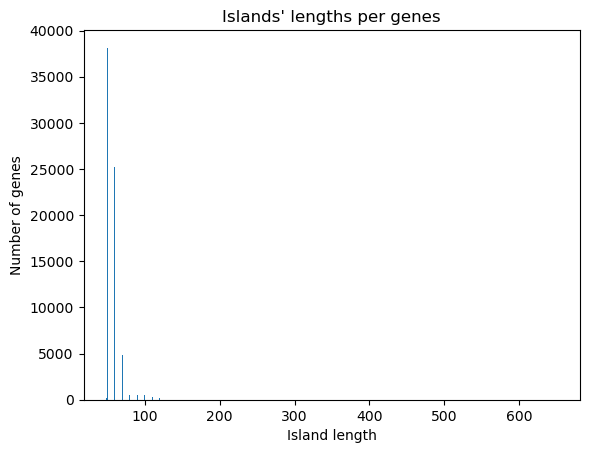

In [28]:
import  collections
import matplotlib.pyplot as plt

lens = []
indices = []
maxim = -1
max_index = -1
for index, islands in enumerate(binding_sites):
    for length in islands[2]:
        if length > maxim:
            maxim = length
            max_index = index
        lens.append(length)
        indices.append(index)

w = collections.Counter(lens)
w = collections.OrderedDict(sorted(w.items()))
print(w)
# plt.ylim(0, 50)
plt.bar(w.keys(), w.values())
plt.xlabel('Island length')
plt.ylabel('Number of genes')
plt.title('Islands\' lengths per genes')

[17697  2832  5930 10839  3995  1108] [     0    500   1000   2000   5000  10000 100000]


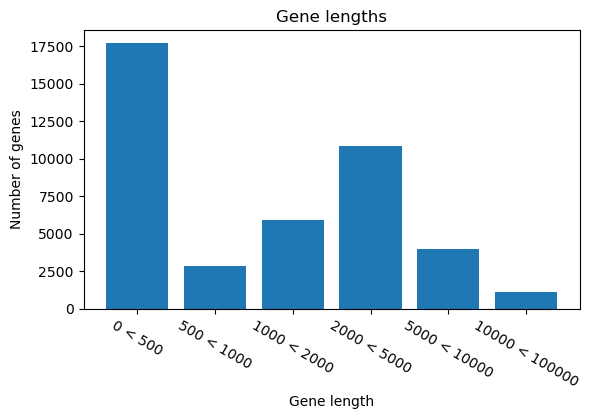

In [45]:
# genes lenghts
genes_lengths = [len(x[1]) for x in miRNA_to_gene_score_loaded[my_miRNA]]
bins = [0, 500, 1000, 2000, 5000, 10000, 100000]
w, bins = np.histogram(genes_lengths, bins)
print(w, bins)
# w = collections.Counter(genes_lengths)
# w = collections.OrderedDict(sorted(w.items()))
# print(w)
# plt.ylim(0, 50)
# plt.bar(w.keys(), w.values())
# plt.bar(w[0], w[1])
plt.bar([str(bins[index]) + ' < ' + str(x) for index, x in enumerate(bins[1:])], w)
# plt.hist(w, bins, histtype='step',edgecolor='r',linewidth=3)
plt.xticks(rotation=-30)
plt.ylabel('Number of genes')
plt.xlabel('Gene length')
plt.title('Gene lengths')
plt.subplots_adjust(bottom=0.3)
plt.savefig('Gene lengths', dpi=300)

(array([ 730, 1630, 2110, 2200, 2330, 2460, 2590, 4620]), array([ 780, 1680, 2170, 2300, 2430, 2560, 3240, 4670]), array([ 50,  50,  60, 100, 100, 100, 650,  50]))


Text(0, 0.5, 'Attribution score')

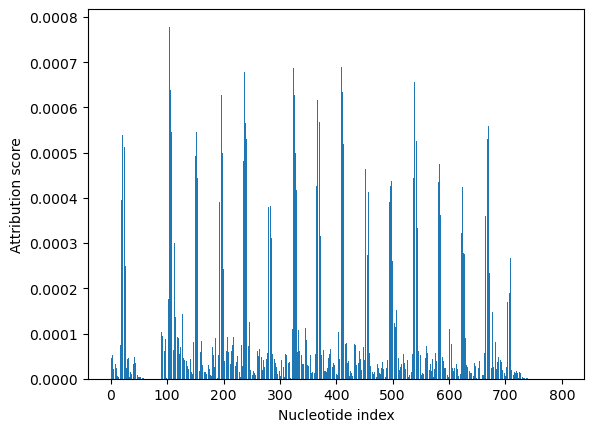

In [47]:
print(binding_sites[max_index])

tmp = miRNA_to_gene_score_loaded[my_miRNA][max_index][1][2500:3300]
plt.bar(range(len(tmp)), tmp)
plt.xlabel('Nucleotide index')
plt.ylabel('Attribution score')

In [48]:
# A generator comprehension gives us an iterable object...
len180_bs_indices = [i for i, e in enumerate(lens) if e == 180]
len180_gene_score_indices = [indices[i] for i in len180_bs_indices]
len180_gene_score_indices

[253, 5842, 12864, 20085, 29177]

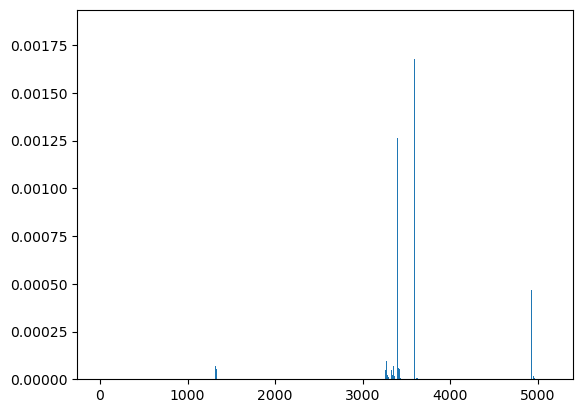

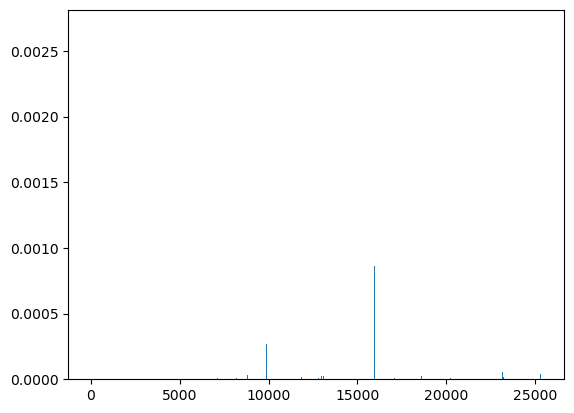

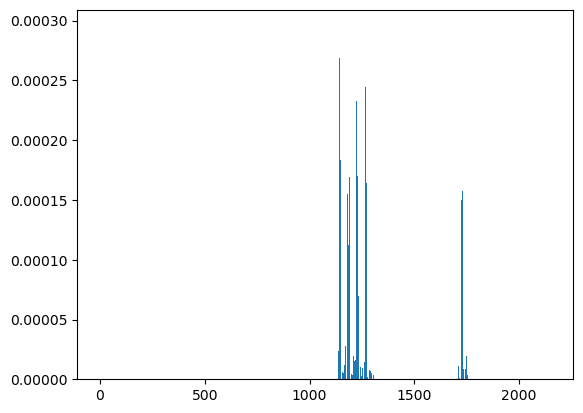

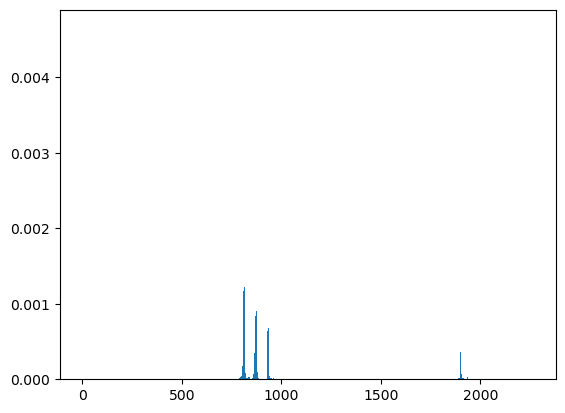

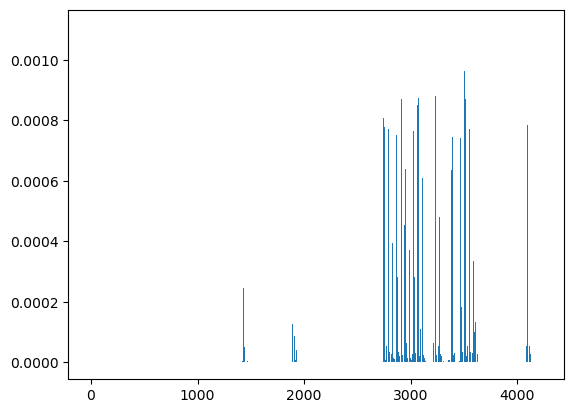

In [49]:
for i in len180_gene_score_indices:
    tmp = miRNA_to_gene_score_loaded[my_miRNA][i][1]
    plt.bar(range(len(tmp)), tmp)
    plt.show()

Text(0, 0.5, 'Attribution score')

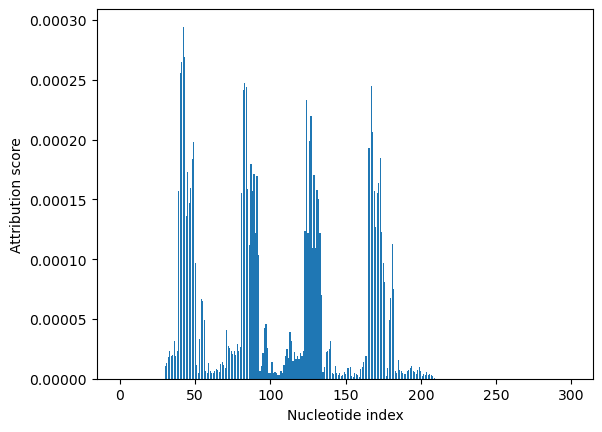

In [50]:
tmp = miRNA_to_gene_score_loaded[my_miRNA][len180_gene_score_indices[2]][1][1100:1400]
plt.bar(range(len(tmp)), tmp)
plt.xlabel('Nucleotide index')
plt.ylabel('Attribution score')

In [51]:
len70_gene_score_indices = [i for l, i in zip(lens, indices) if l == 70]

In [52]:
zoom_coord = {}
for i in len70_gene_score_indices:
    possitions_of_desired_length = [pos for pos, length in enumerate(binding_sites[i][-1]) if length == 70]
    zoom_coord[i] = [(binding_sites[i][0][x], binding_sites[i][1][x]) for x in possitions_of_desired_length]

list(zoom_coord.items())[:5]

[(22, [(2530, 2600), (10160, 10230)]),
 (28, [(320, 390)]),
 (31, [(1390, 1460)]),
 (46, [(20, 90)]),
 (53, [(100, 170)])]

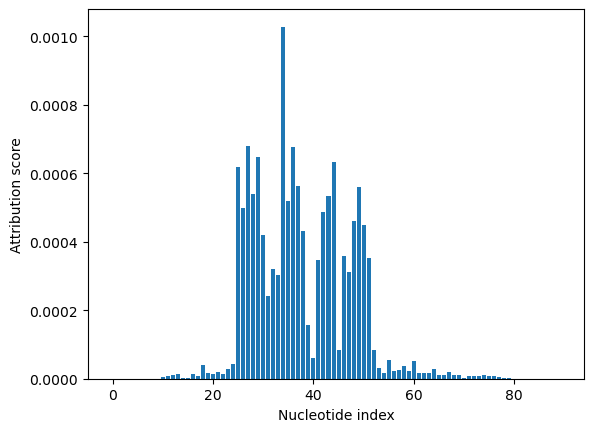

(array([ 2020,  2230,  2530,  2930,  3940,  4410,  8700, 10160, 10740]), array([ 2080,  2330,  2600,  2980,  3990,  4460,  8750, 10230, 10800]), array([ 60, 100,  70,  50,  50,  50,  50,  70,  60]))


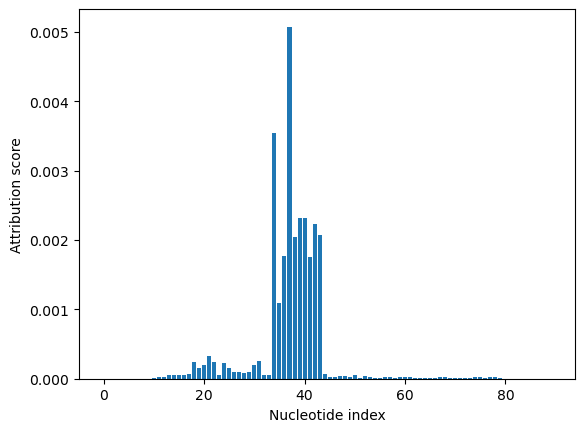

(array([ 2020,  2230,  2530,  2930,  3940,  4410,  8700, 10160, 10740]), array([ 2080,  2330,  2600,  2980,  3990,  4460,  8750, 10230, 10800]), array([ 60, 100,  70,  50,  50,  50,  50,  70,  60]))


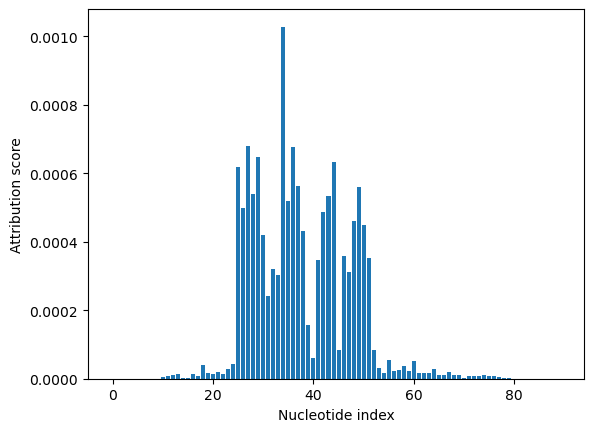

(array([ 2020,  2230,  2530,  2930,  3940,  4410,  8700, 10160, 10740]), array([ 2080,  2330,  2600,  2980,  3990,  4460,  8750, 10230, 10800]), array([ 60, 100,  70,  50,  50,  50,  50,  70,  60]))


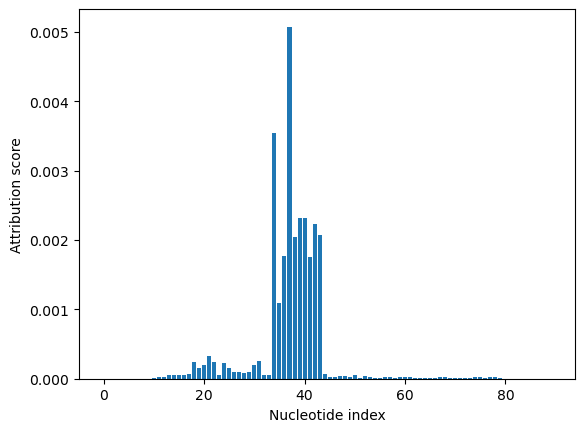

(array([ 2020,  2230,  2530,  2930,  3940,  4410,  8700, 10160, 10740]), array([ 2080,  2330,  2600,  2980,  3990,  4460,  8750, 10230, 10800]), array([ 60, 100,  70,  50,  50,  50,  50,  70,  60]))


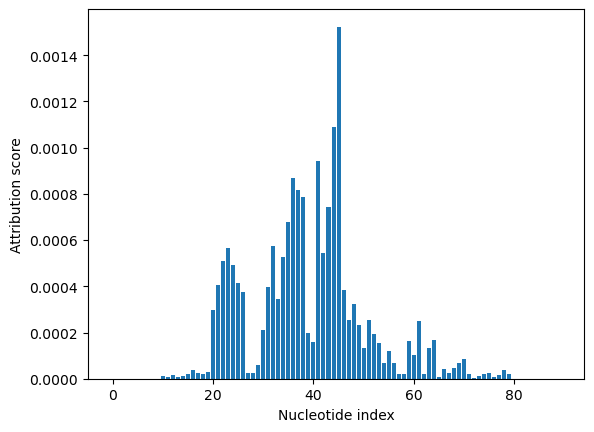

(array([320]), array([390]), array([70]))


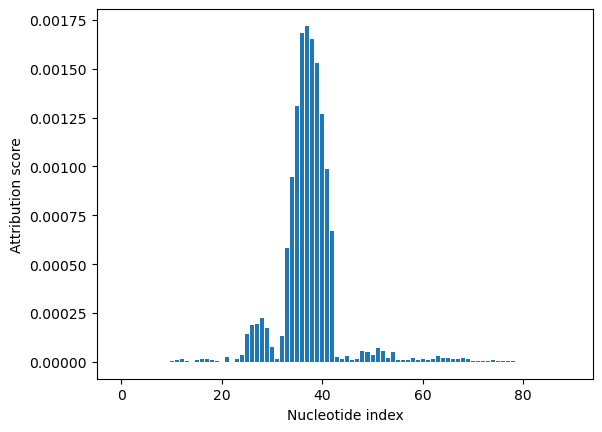

(array([  70,  920, 1320, 1390]), array([ 170,  980, 1370, 1460]), array([100,  60,  50,  70]))


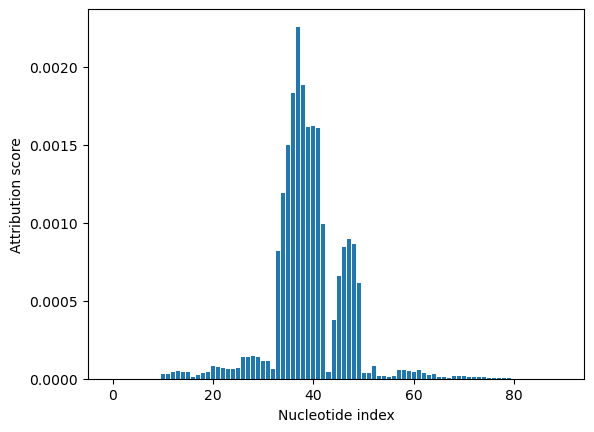

(array([  20, 1380, 2470, 4420]), array([  90, 1430, 2520, 4470]), array([70, 50, 50, 50]))


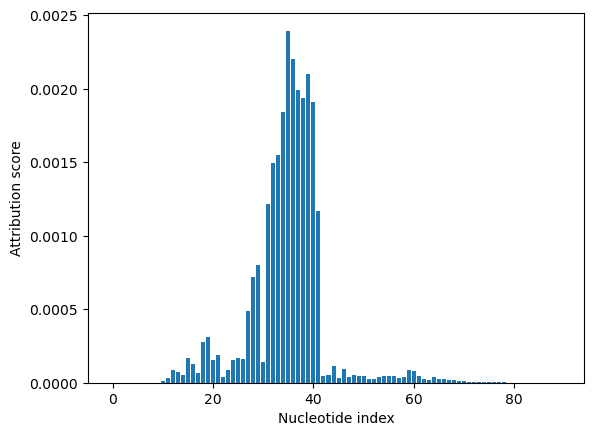

(array([ 100, 1390]), array([ 170, 1450]), array([70, 60]))


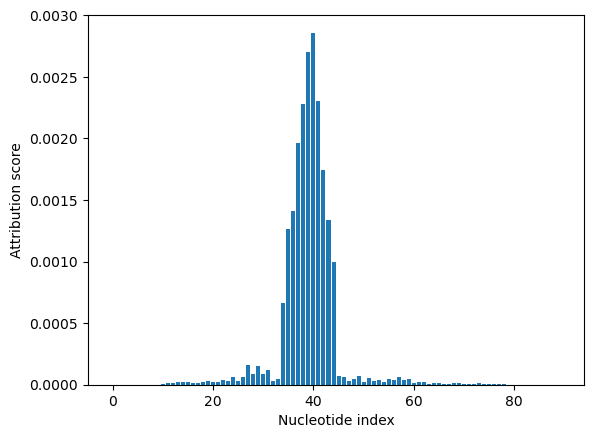

(array([180]), array([250]), array([70]))


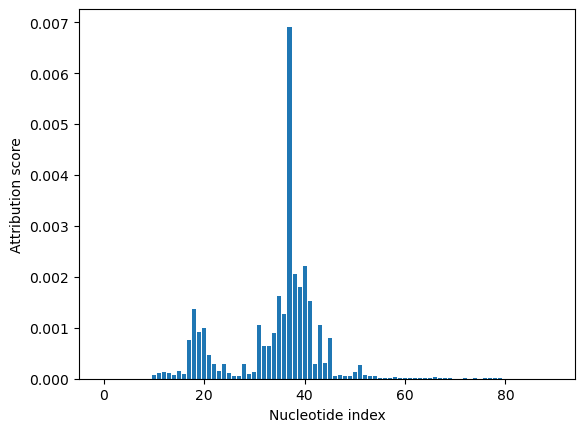

(array([1000]), array([1070]), array([70]))


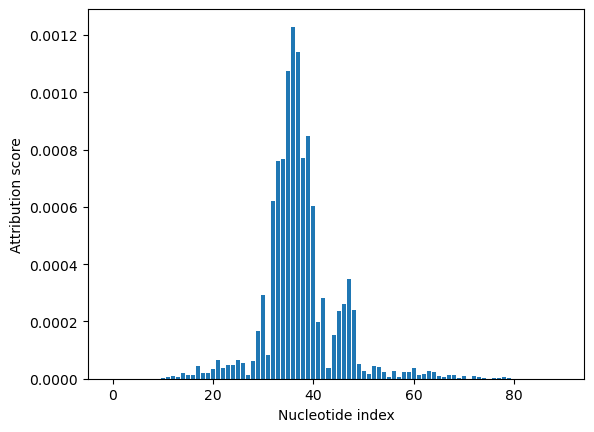

(array([ 890, 1420, 1790, 2140, 3230]), array([ 960, 1480, 1860, 2190, 3310]), array([70, 60, 70, 50, 80]))


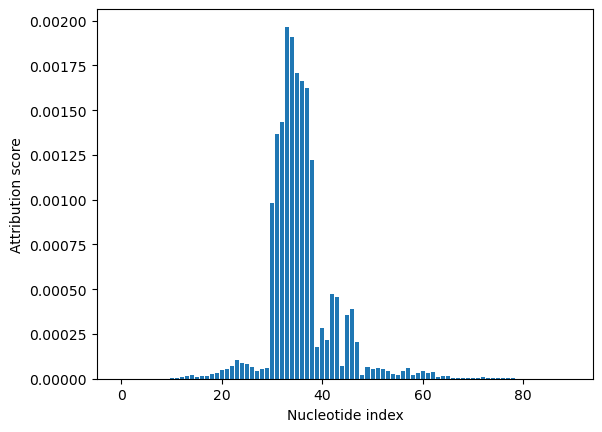

(array([ 890, 1420, 1790, 2140, 3230]), array([ 960, 1480, 1860, 2190, 3310]), array([70, 60, 70, 50, 80]))


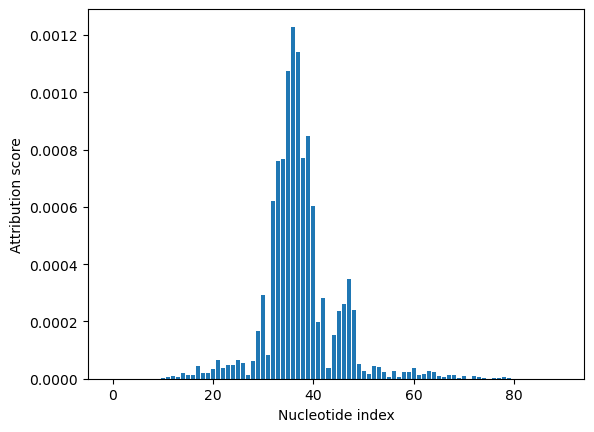

(array([ 890, 1420, 1790, 2140, 3230]), array([ 960, 1480, 1860, 2190, 3310]), array([70, 60, 70, 50, 80]))


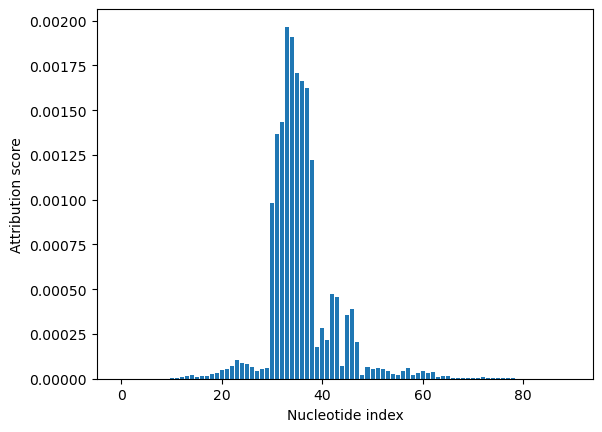

(array([ 890, 1420, 1790, 2140, 3230]), array([ 960, 1480, 1860, 2190, 3310]), array([70, 60, 70, 50, 80]))


In [53]:
for i in len70_gene_score_indices[:10]:
    for zoom_start, zoom_end in zoom_coord[i]:
        tmp = miRNA_to_gene_score_loaded[my_miRNA][i][1][zoom_start-10 : zoom_end+10]
        plt.bar(range(len(tmp)), tmp)        
        plt.xlabel('Nucleotide index')
        plt.ylabel('Attribution score')
        plt.show()
        print(binding_sites[i])

In [54]:
import pandas as pd 

distribution_separation_data = []
distribution_separation_data.append(miRNA_to_gene_score_loaded[my_miRNA][max_index][1][2500:3300])
distribution_separation_data.append(miRNA_to_gene_score_loaded[my_miRNA][len180_gene_score_indices[3]][1][750:1000])
distribution_separation_data.append(miRNA_to_gene_score_loaded[my_miRNA][len180_gene_score_indices[2]][1][1100:1400])
df = pd.DataFrame(distribution_separation_data)
df.to_csv("distribution_separation_data.csv", header=False, index=False)

### Count the statistics for input data

In [55]:
from modules.collect_scores.bymaxvalue import bymaxvaluefunc
from modules.collect_scores.bymean import bymeanfunc


input_data = []
input_data_genes = []
transcripts_with_no_bs = []
FEATURES = [0, 1, 2, 3]
FEATURE_NAMES = ['max', 'mean', 'bs_start', 'transcript_len']


scores_per_gene = miRNA_to_gene_score_loaded[my_miRNA]

statistical_funcs = [bymaxvaluefunc, bymeanfunc]
# and starting index

# for each gene
for i in range(len(scores_per_gene)):
    scores = scores_per_gene[i][1]
    gene_name = scores_per_gene[i][0]
    seq_binding = []
    starts, ends, lengths = binding_sites[i]
    
    # for each binding site: count features
    for k in range(len(starts)):
        
        if starts[k].any():
        # if start.size > 0:
            # this dictates the number of features
            stat_one = statistical_funcs[0](scores[starts[k]:ends[k]])
            stat_two = statistical_funcs[1](scores[starts[k]:ends[k]])
            # TODO think about the modeling of input data because now the " len(scores)" is the same number in every binding site (quartet) of single transcript
            seq_binding.append([stat_one, stat_two, starts[k], len(scores)])
        else:
            seq_binding.append([0, 0, 0, 0])
            
    if len(seq_binding) > 0:
        input_data.append(seq_binding)
        input_data_genes.append(gene_name)
    else:
        transcripts_with_no_bs.append(gene_name)

In [56]:
len(input_data),  input_data[1],  input_data[4]

(25629,
 [[0.0020709490776062013, 0.0002585863833349625, 1300, 1521]],
 [[0.000854843556880951, 0.00011655626766732893, 2340, 4244],
  [0.0004107185825705528, 6.734315702051388e-05, 4090, 4244]])

In [57]:
start, end, length = binding_sites[0]
print(start, end, length)
type(start)

[860] [910] [50]


numpy.ndarray

In [58]:
len(binding_sites[3])

3

In [59]:
bs_count = []
for i in input_data:
    # if 
    bs_count.append(len(i))

### Number of binding sites per transcript


OrderedDict([(0, 16773), (1, 10378), (2, 5922), (3, 3445), (4, 2088), (5, 1250), (6, 761), (7, 498), (8, 346), (9, 225), (10, 145), (11, 138), (12, 93), (13, 53), (14, 60), (15, 40), (16, 32), (17, 21), (18, 15), (19, 11), (20, 11), (21, 13), (22, 5), (23, 9), (24, 6), (25, 9), (26, 3), (27, 10), (28, 5), (29, 6), (30, 6), (31, 2), (32, 2), (33, 2), (34, 2), (35, 3), (36, 1), (37, 2), (38, 1), (44, 2), (45, 2), (48, 1), (53, 1), (62, 1), (64, 1), (65, 1), (66, 1)])


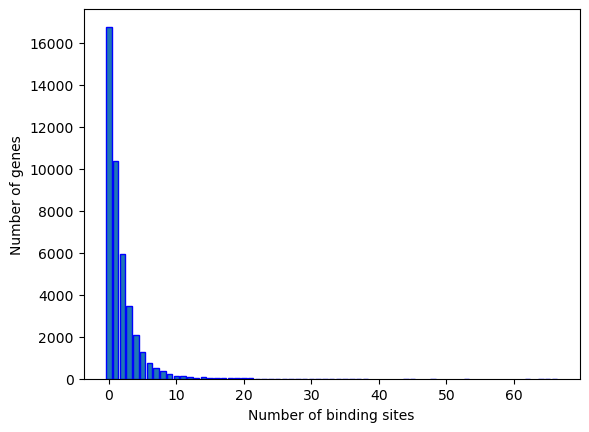

In [64]:
import  collections
import matplotlib.pyplot as plt
w = collections.Counter(bs_count)
w[0] = len(transcripts_with_no_bs)
w = collections.OrderedDict(sorted(w.items()))
print(w)
plt.bar(w.keys(), w.values(), ec='blue')
plt.xlabel('Number of binding sites')
plt.ylabel('Number of genes')
plt.show()

# plt.figure(num = random.randint(0, 1000)) # num is a unique identifier for the figure
# plt.plot(collections.Counter(bs_count));

### binding sites per gene distribution 

In [81]:
w_min = np.min(list(w.values()))
w_max = np.max(list(w.values()))
w_perc = [(x - w_min) / (w_max - w_min) for x in w.values()]


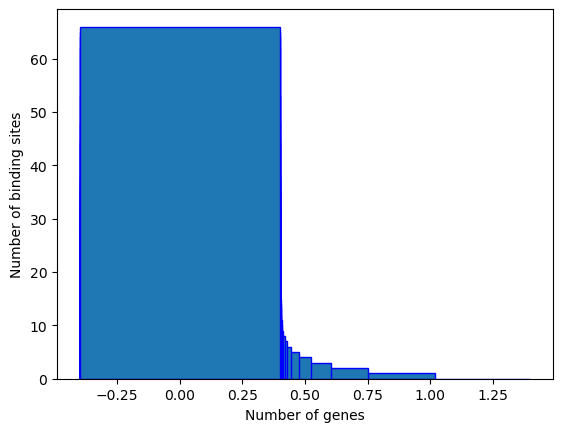

In [89]:
# binding sites per gene distribution 
plt.bar([(x - w_min) / (w_max - w_min)  for x in w.values()], w.keys(), ec='blue')
plt.ylabel('Number of binding sites')
plt.xlabel('Number of genes')
plt.show()

### Normalize input data

#### TODO should we do some more complex normalization/preprocessing based on the shape/statistics of the data? --- a lot of low values; take outliers into acount when choosing normalization method?

In [43]:
input_data[5], input_data[1]

([[0.0005550672113895416, 7.100176308886147e-05, 450, 5961],
  [0.0003475658968091011, 7.346505898676696e-05, 1230, 5961],
  [0.00019479231908917427, 3.8508949094102705e-05, 2010, 5961],
  [0.0016985791968181728, 0.0002653615775329855, 2560, 5961],
  [0.0011792104318737984, 0.0001531407045658853, 2650, 5961],
  [0.0003918356075882912, 6.104532821627802e-05, 5400, 5961]],
 [[0.0020709490776062013, 0.0002585863833349625, 1300, 1521]])

In [44]:
feature_maxmins = {}

for feature in FEATURES:
    x_min = 999999
    x_max = -1
    for sample in input_data:
        for binding_site in sample:
            item = binding_site[feature]
            if x_min > item:
                x_min = item
            if x_max < item:
                x_max = item
    
    feature_maxmins['feature' + str(feature)] = (x_min, x_max)
    
print("maxes and mins")
feature_maxmins

maxes and mins


{'feature0': (0.0001069104764610529, 0.4938503155484796),
 'feature1': (2.6173551956890148e-05, 0.0348073390016565),
 'feature2': (1, 100270),
 'feature3': (58, 100785)}

In [45]:
input_data_normalized = []

for sample in input_data:
    new_sample = []
    for binding_site in sample:
        new_binding_site = []
        for feature in FEATURES:
            x_min = list(feature_maxmins.items())[feature][1][0]
            x_max = list(feature_maxmins.items())[feature][1][1]
            item = binding_site[feature]
            item = (item - x_min) / (x_max - x_min)
            new_binding_site.append(item)
        new_sample.append(new_binding_site)
    input_data_normalized.append(new_sample)    

In [46]:
print(input_data_normalized[5])
print(input_data_normalized[1])

[[0.0009076713335808902, 0.0012888645493148213, 0.004477954302925131, 0.05860394928867136], [0.0004874098932277296, 0.0013596872450484618, 0.012257028593084602, 0.05860394928867136], [0.00017799091942362802, 0.00035465738360757233, 0.02003610288324407, 0.05860394928867136], [0.00322367590940269, 0.006876941082437509, 0.02552134757502319, 0.05860394928867136], [0.0021717757531492243, 0.003650457107097649, 0.02641893307004159, 0.05860394928867136], [0.0005770712645481887, 0.001002605168875646, 0.053845156528937156, 0.05860394928867136]]
[[0.003977852829970801, 0.006682146166556348, 0.01295515064476558, 0.014524407557060172]]


### Explore input features distribution

#### Reshape features - group them by feature type (== stat1, stat2, ...) instead of by samplebinding_site

In [47]:
from math import log
from sklearn.preprocessing import normalize
#TODO try
# from sklearn.preprocessing import robust_scale

# original values
features_grouped = [[] for x in FEATURES]
for sample in input_data:
    for binding_site_statistics in sample:
        for index in FEATURES:    
            features_grouped[index].append(binding_site_statistics[index])
            
            
# <0,1> scale
# v1
# features_grouped_normalized = [[] for x in FEATURES]
# features_grouped_normalized = normalize(features_grouped)
# v0
features_grouped_normalized = [[] for x in FEATURES]
for sample in input_data_normalized:
    for binding_site_statistics in sample:
        for index in FEATURES:    
            features_grouped_normalized[index].append(binding_site_statistics[index])
            
# log scale
features_grouped_logs = [[] for x in FEATURES]
for sample in input_data:
    for binding_site_statistics in sample:
        for index in FEATURES:    
            features_grouped_logs[index].append(log(1+binding_site_statistics[index]))


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def multi_bar_plot(data):
    sns.set_style('whitegrid')
    g = sns.catplot(x="signal values", y="counts",
                    # col="year",
                    data=data,
                    kind="bar", height=3, aspect=.7, palette='viridis')
    print(data)
    for ax in g.axes.flat[1:]:
        sns.despine(ax=ax, left=True)
    for ax in g.axes.flat:
        ax.set_xlabel(ax.get_title())
        ax.set_title('')
        ax.margins(x=0.03)
        ax.tick_params(axis='x', labelrotation=90)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

In [49]:
# sns.load_dataset("flights")

['max', 'mean', 'bs_start', 'transcript_len']


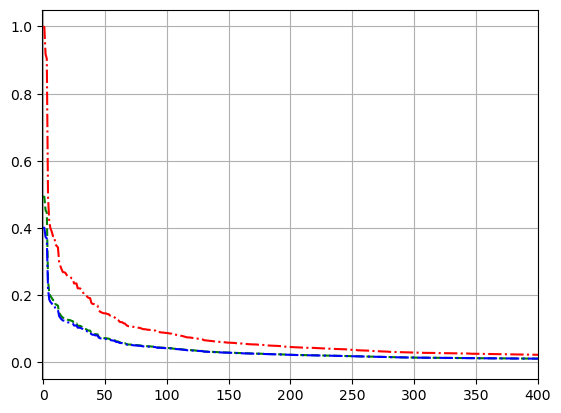

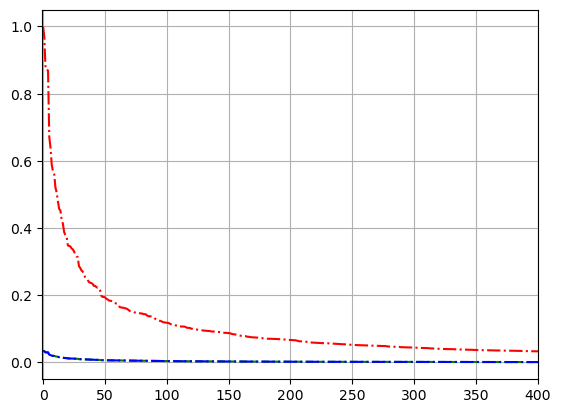

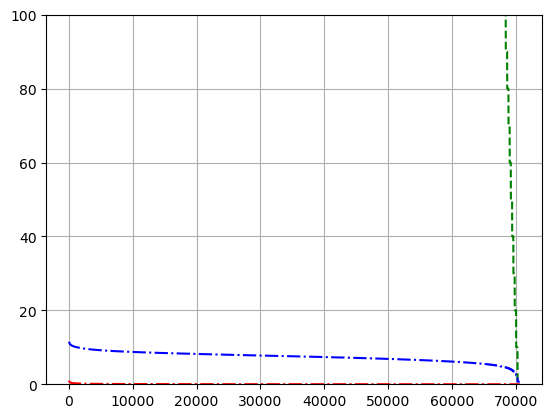

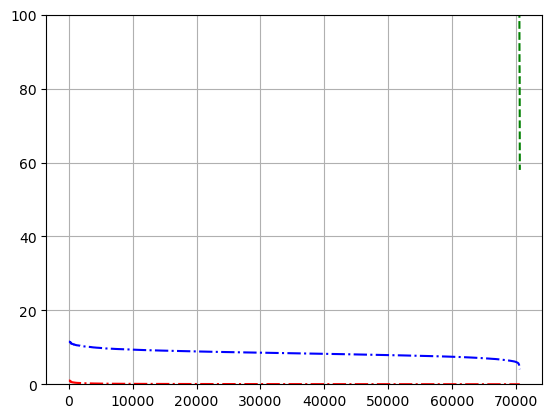

In [50]:
from collections import Counter
print(FEATURE_NAMES)

for i in FEATURES:
    features_grouped[i].sort(reverse=True)
    # features_grouped_normalized[i].sort(reverse=True)
    features_grouped_normalized[i].sort()
    features_grouped_normalized[i] = np.flip(features_grouped_normalized[i])
    features_grouped_logs[i].sort(reverse=True)

for i in FEATURES[:-2]:
    ax = plt.gca()
    ax.set_xlim([-1, 400])
    # ax.set_ylim([ymin, ymax])
    plt.grid(visible=True)
    #____
    rounded = [ round(elem, 4) for elem in features_grouped[i]]
    # w = Counter(rounded)
    # multi_bar_plot(
    #     pd.DataFrame(list(zip(w.keys(), w.values())),
    #     columns =['signal values', 'counts'])
    #)   
    #____
    # plt.bar(w.keys(), w.values())
    #____
    plt.plot(features_grouped[i],'g--', label="raw")
    plt.plot(features_grouped_normalized[i],'r-.', label="normalized")
    plt.plot(features_grouped_logs[i],'b-.', label="normalized")
    #____
    # plt.plot(features_grouped[i], features_grouped_normalized[i])
    #____
    # plt.ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    plt.show()
    
for i in [2,3]:
    ax = plt.gca()
    # ax.set_xlim([-1, 11000])
    ax.set_ylim([0, 100])
    plt.grid(visible=True)
    plt.plot(features_grouped[i],'g--', label="raw")
    plt.plot(features_grouped_normalized[i],'r-.', label="normalized")
    plt.plot(features_grouped_logs[i],'b-.', label="normalized")
    # plt.plot(features_grouped[i], features_grouped_normalized[i])
    # plt.ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    plt.show()

### Padding input data to 10 binding sites per sample

In [51]:
print(len(input_data_normalized))
print(input_data_normalized[4])

flatten_input = []
for sample in input_data_normalized:
    flatten_sample = []
    for bs in sample:
        flatten_sample.extend(bs)
    flatten_input.append(flatten_sample)

25629
[[0.0015148214087250499, 0.0025986109016717662, 0.023327249698311542, 0.04155787425417217], [0.0006153157753371628, 0.0011836752601968746, 0.040780300990336, 0.04155787425417217]]


In [52]:
print(len(flatten_input))
print(flatten_input[4])

25629
[0.0015148214087250499, 0.0025986109016717662, 0.023327249698311542, 0.04155787425417217, 0.0006153157753371628, 0.0011836752601968746, 0.040780300990336, 0.04155787425417217]


In [53]:
import torch
import torch.nn.functional as F

# Convert to tensor
data_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(item) for item in flatten_input], batch_first=True)

# Calculate the padding required
padding = (0, (len(FEATURES) * 10) - data_tensor.size(1))

# Pad with zeros
padded_data_tensor = F.pad(data_tensor, padding, value=0)

In [54]:
len(padded_data_tensor), padded_data_tensor[0].size(), padded_data_tensor[0]

(25629,
 torch.Size([40]),
 tensor([0.0015, 0.0022, 0.0086, 0.0486, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64))

### Add labels

In [55]:
# input_data_genes

mirna_FCs = pd.read_csv('mirna_fcs.csv',index_col=0, header=0, sep=',')
# mirna_FCs[['Gene symbol',my_miRNA_name]]

mirna_FCs_dict = mirna_FCs.set_index('Gene symbol')['hsa-miR-106b-5p'].to_dict()
# df_dict

input_labels_unfiltered = []
not_found_genes = []
gene_indices_to_remove = []
nan_genes = []

for i, gene in enumerate(input_data_genes):
    try:
        fc = mirna_FCs_dict[gene]
        if np.isnan(fc):
            nan_genes.append(gene)
            input_labels_unfiltered.append(0)
            gene_indices_to_remove.append(i)            
        else:
            input_labels_unfiltered.append(fc)
    except:
        not_found_genes.append(gene)
        input_labels_unfiltered.append(0)
        gene_indices_to_remove.append(i)

In [56]:
"There is ", len(not_found_genes), "genes for which we do not have fold change because they are not in the Bartel table, out of total", len(input_labels_unfiltered), "and", len(nan_genes), "nan valued genes in FC table"

('There is ',
 20167,
 'genes for which we do not have fold change because they are not in the Bartel table, out of total',
 25629,
 'and',
 171,
 'nan valued genes in FC table')

### Filter genes without fold change from the dataset

In [57]:
num_genes = len(input_data_genes)

for i in gene_indices_to_remove:
    input_labels_unfiltered[i] = "remove"

input_labels =  [i for i in input_labels_unfiltered if i != "remove"]
padded_data_tensor =  [padded_data_tensor[i] for i in range(len(input_labels_unfiltered)) if input_labels_unfiltered[i] != "remove"]
input_data_genes_filtered = [input_data_genes[i] for i in range(len(input_labels_unfiltered)) if input_labels_unfiltered[i] != "remove"]

In [58]:
len(input_labels), len(padded_data_tensor)

(5291, 5291)

In [59]:
for i in range(2):
    print(padded_data_tensor[i])


tensor([0.0017, 0.0028, 0.0145, 0.0192, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
tensor([0.0042, 0.0071, 0.0013, 0.0146, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)


### Split train/validation/test

#### Create test set based on what genes we can compare on with Bartel

In [60]:
targetscan = pd.read_csv('Predicted_Targets_Context_Scores.default_predictions.txt',index_col=0, header=0, sep='\t')
targetscan = targetscan[["context++ score","weighted context++ score","miRNA","Gene Symbol"]]
targetscan = targetscan[targetscan['miRNA'] == mirna_name]

bartel_gene_names = targetscan['Gene Symbol'].to_numpy().flatten()

bartel_test_samples = set(bartel_gene_names).intersection(
    set(mirna_FCs[["Gene symbol"]].to_numpy().flatten())).intersection(
    set(input_data_genes_filtered))

len(bartel_test_samples)

580

In [61]:
from sklearn.model_selection import train_test_split

BARTEL_SPLIT = True


if BARTEL_SPLIT:
    # x_train, x_test, y_train, y_test = train_test_split(padded_data_tensor, input_labels, test_size=0.2, random_state=42)
    # Split the data and gene names simultaneously
    indecis = []
    x_train, x_test, y_train, y_test, gene_names_train, gene_names_test = [],[],[],[],[],[]
    
    for sample, label, name in zip(padded_data_tensor, input_labels, input_data_genes_filtered):
        if name in bartel_test_samples:
            x_test.append(sample)
            y_test.append(label)
            gene_names_test.append(name)
        else:
            x_train.append(sample)
            y_train.append(label)
            gene_names_train.append(name)
    print(len(x_train), len(x_test))

    # validation
    x_train, x_val, y_train, y_val, gene_names_train, gene_names_val = train_test_split(x_train, y_train, gene_names_train, test_size=0.1, random_state=42)

    print(len(y_train), len(y_val), len(y_test))
    print(len(gene_names_train), len(gene_names_val), len(gene_names_test))
else:
    # x_train, x_test, y_train, y_test = train_test_split(padded_data_tensor, input_labels, test_size=0.2, random_state=42)
    # Split the data and gene names simultaneously
    (x_train, x_test, y_train, y_test, gene_names_train, gene_names_test) = train_test_split(
        padded_data_tensor, input_labels, input_data_genes_filtered, test_size=0.2, random_state=42)

        #validation
    x_train, x_val, y_train, y_val, gene_names_train, gene_names_val = train_test_split(x_train, y_train, gene_names_train, test_size=0.1, random_state=42)

    print(len(y_train), len(y_val), len(y_test))
    print(len(gene_names_train), len(gene_names_val), len(gene_names_test))


4711 580
4239 472 580
4239 472 580


### Make a datasets


In [62]:
from torch.utils.data import Dataset, DataLoader, TensorDataset


test_dataset = TensorDataset(torch.stack(x_test).unsqueeze(1).float(), torch.tensor(y_test).unsqueeze(dim=1))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class TrainDataset(Dataset):
    def __init__(self, data, labels, exps):
        self.data = data
        self.labels = labels
        self.exps = exps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        exp = self.exps[idx]
        return x, y, exp
    
class ValDataset(Dataset):
    def __init__(self, data, labels, identifiers):
        self.data = data
        self.labels = labels
        self.identifiers = identifiers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        identifier = self.identifiers[idx]
        return x, y, identifier

#dummy exps and indentifiers
exps = [1 for x in range(len(y_train))]
identifiers = []
for label in y_val:
    item = {}
    item['readid']=0
    item['label']=label
    item['exp']=1
    identifiers.append(item)


train_dataset = TrainDataset(torch.stack(x_train).unsqueeze(1).float(), torch.tensor(y_train).unsqueeze(dim=1), exps)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ValDataset(torch.stack(x_val).unsqueeze(1).float(), torch.tensor(y_val).unsqueeze(dim=1), identifiers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [63]:
np.count_nonzero(np.isnan(y_train)), np.count_nonzero(~np.isnan(y_train))

(0, 4239)

### Set up logging

In [64]:
comet_logger = CometLogger(
    api_key="EpKIINrla6U4B4LJhd9Sv4i0b",
    project_name="mirna",
)

CometLogger will be initialized in online mode


### Train a simple network 

In [104]:
import torch
import torchmetrics
import pytorch_lightning as pl
from types import SimpleNamespace
import numpy as np
import re
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from modules.models.modules import ConvNet, RNNEncoder, MLP, Attention, Permute, SimpleCNN # , BigConvNet, ResConvNet
from sklearn.metrics import average_precision_score
import csv

from model import Small_CNN

In [105]:
from pytorch_lightning import Trainer
from IPython.utils import io


model = Small_CNN(pooling='att')
# trainer = Trainer(max_epochs=1, gpus=1)  # Use GPU if available, train for X epochs
trainer = Trainer(logger=comet_logger, max_epochs=3)  # Use GPU if available, train for X epochs

with io.capture_output() as captured:
    trainer.fit(model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | architecture | Sequential        | 350   
1 | ce           | MSELoss           | 0     
2 | mae          | MeanAbsoluteError | 0     
3 | mse          | MeanSquaredError  | 0     
4 | r2           | R2Score           | 0     
---------------------------------------------------
350       Trainable params
0         Non-trainable params
350       Total params
0.001     Total estimated model params size (MB)
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.c

### Test

In [106]:
model, test_loader


(Small_CNN(
   (architecture): Sequential(
     (0): SimpleCNN(
       (layers): Sequential(
         (0): Sequential(
           (0): Conv1d(1, 8, kernel_size=(4,), stride=(4,))
           (1): ReLU()
           (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
         )
       )
     )
     (1): Permute()
     (2): Attention(
       (attention): Linear(in_features=8, out_features=1, bias=True)
     )
     (3): MLP(
       (layers): Sequential(
         (0): Linear(in_features=8, out_features=30, bias=True)
         (1): ReLU()
         (2): Linear(in_features=30, out_features=1, bias=True)
       )
     )
   )
   (ce): MSELoss()
   (mae): MeanAbsoluteError()
   (mse): MeanSquaredError()
   (r2): R2Score()
 ),
 <torch.utils.data.dataloader.DataLoader at 0x7fc0fb63c610>)

In [107]:
result = trainer.test(model, test_loader)

Testing DataLoader 0: 100%|██████████| 19/19 [00:00<00:00, 358.86it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/davidcechak/mirna/647f4cc8b5734082bd096065d1fff7ca



Testing DataLoader 0: 100%|██████████| 19/19 [00:01<00:00, 13.17it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.24228496849536896    │
│            mse            │    0.09894933551549911    │
│            r2             │    -1.160277009010315     │
│           rmse            │    0.3090278208255768     │
│         test_loss         │    0.09894933551549911    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/davidcechak/mirna/647f4cc8b5734082bd096065d1fff7ca
COMET INFO:   Metrics:
COMET INFO:     mae       : 0.24228496849536896
COMET INFO:     mse       : 0.09894933551549911
COMET INFO:     r2        : -1.160277009010315
COMET INFO:     rmse      : 0.3090278208255768
COMET INFO:     test_loss : 0.09894933551549911
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 22 metrics, params and output messages


In [68]:
result

[{'test_loss': 0.09942469000816345,
  'mse': 0.09942469000816345,
  'mae': 0.243251770734787,
  'r2': -1.1794437170028687,
  'rmse': 0.30987563729286194}]

In [69]:
# feature_maxmins, FEATURE_NAMES
# torch.stack(x_test).unsqueeze(1).float(), torch.tensor(y_test).unsqueeze(dim=1)
from statistics import mean

print(mean(y_train), min(y_train), max(y_train))
print(mean(y_test), min(y_test), max(y_test))

# Baseline: mean of the training dataset labels
baseline = mean(y_train)
baseline_mean = torchmetrics.MeanAbsoluteError()(torch.tensor(np.full((len(y_test),), baseline)), torch.tensor(np.array(y_test)))
print('MAE: Our prediction is better by ', baseline_mean.item() - result[0]['mae'], ' our MAE: ', result[0]['mae'], '; mean-baseline MAE: ', baseline_mean.item())

print('Baseline metrics: ')
model.get_metrics(torch.tensor(np.full((len(y_test),), mean(y_train))), torch.tensor(np.array(y_test)), None)

0.015894314696862467 -0.983 0.961
-0.17517241379310344 -1.255 0.397
MAE: Our prediction is better by  -0.015934064984321594  our MAE:  0.243251770734787 ; mean-baseline MAE:  0.2273177057504654
Baseline metrics: 


{'mse': tensor(0.0903),
 'mae': tensor(0.2273),
 'r2': tensor(-0.6784),
 'rmse': tensor(0.3005)}

### Predict

In [70]:
# predictions = model(torch.randn(2, 1, 40))
# trainer.predict(

with torch.no_grad(): # Disables gradient computation, as it's not needed during evaluation
    predictions = model(torch.stack(x_test).unsqueeze(1).float())
print(predictions.squeeze(1).shape)

gene_to_predictions = {}
for i in range(len(gene_names_test)):
    gene_to_predictions[gene_names_test[i]] = predictions.squeeze(1)[i].item()
    
print(list(gene_to_predictions.items())[:2])

predictions_scalar = [x.item() for x in predictions.squeeze(1)]

torch.Size([580])
[('PSEN1', 0.04943828284740448), ('LAMA3', 0.053304463624954224)]


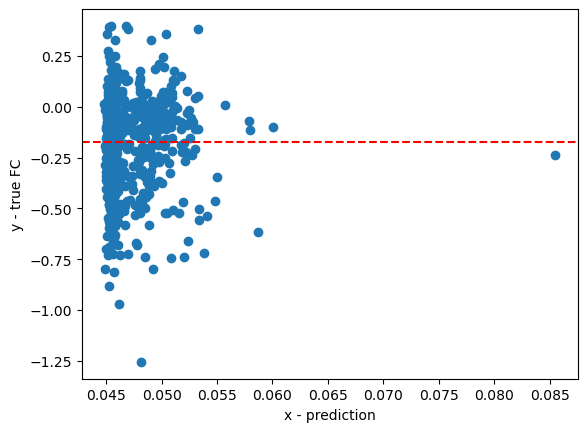

In [110]:
plt.scatter(predictions_scalar, y_test)
plt.axhline(y = mean(y_test), color = 'r', linestyle = '--')  
plt.xlabel('x - prediction')
plt.ylabel('y - true FC')
plt.show()

### Bartel metrics 

In [72]:
# targetscan = pd.read_csv('Predicted_Targets_Context_Scores.default_predictions.txt',index_col=0, header=0, sep='\t')
# targetscan = targetscan[["context++ score","weighted context++ score","miRNA","Gene Symbol"]]
# targetscan = targetscan[targetscan['miRNA'] == mirna_name]

# bartel_gene_names = targetscan['Gene Symbol'].to_numpy().flatten()

bartel_gene_to_score = {row[1]: row[0] for row in targetscan[["weighted context++ score", 'Gene Symbol']].to_numpy()}

In [73]:
ordered_bartel_scores = []
for gene in gene_names_test:
    ordered_bartel_scores.append(bartel_gene_to_score[gene])
len(ordered_bartel_scores)

580

In [74]:
bartel_mae = torchmetrics.MeanAbsoluteError()(torch.tensor(ordered_bartel_scores), torch.tensor(np.array(y_test)))
bartel_mse = torchmetrics.MeanSquaredError()(torch.tensor(ordered_bartel_scores), torch.tensor(np.array(y_test)))
bartel_r2 = torchmetrics.R2Score()(torch.tensor(ordered_bartel_scores), torch.tensor(np.array(y_test)))

print('Bartel metrics:')
print('mae', bartel_mae.item())
print('mse', bartel_mse.item())
print('r2', bartel_r2.item())

Bartel metrics:
mae 0.17373275756835938
mse 0.05209270492196083
r2 0.03201955556869507


### Save predictions to be used for 'Top targets plot'


In [75]:
results_df = pd.DataFrame(gene_to_predictions.items(), columns=["Gene Symbol","score"])
results_df

,Gene Symbol,score
0,PSEN1,0.049438
1,LAMA3,0.053304
2,OCRL,0.045526
3,PKD1,0.049401
4,PON2,0.045017
...,...,...
575,TPRG1L,0.045433
576,SPTY2D1,0.047117
577,ZBTB41,0.051729
578,GALNT10,0.046666


In [76]:
file_name = "our_results_df"
results_df.to_pickle(file_name) 
results_df = pd.read_pickle(file_name)

In [77]:
all_genes = []
for gene_symbol, gene_sequence in gene_symbol_to_seq.items():
    all_genes.append(gene_symbol)

#### (prediction) for genes
X axis is different genes, Y axis is fold change

In [78]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.offline as pyo

pio.renderers.default = 'notebook'
pyo.init_notebook_mode(connected=True)


###Importing dummy data
#Predictions
targetscan = pd.read_csv('Predicted_Targets_Context_Scores.default_predictions.txt',index_col=0, header=0, sep='\t')
targetscan = targetscan[["context++ score","weighted context++ score","miRNA","Gene Symbol"]]
targetscan = targetscan[targetscan['miRNA'] == mirna_name]
#Expression
mirna_FCs = pd.read_csv('mirna_fcs.csv',index_col=0, header=0, sep=',')


predictions = {}

predictions["context++ score"] = targetscan[["context++ score","miRNA","Gene Symbol"]]
predictions["context++ score"] = predictions["context++ score"].rename(columns={'context++ score': 'score'})

predictions["weighted context++ score"] = targetscan[["weighted context++ score","miRNA","Gene Symbol"]]
predictions["weighted context++ score"] = predictions["weighted context++ score"].rename(columns={'weighted context++ score': 'score'})

predictions["our score"] = targetscan[["weighted context++ score","miRNA","Gene Symbol"]]
predictions["our score"] = predictions["weighted context++ score"].rename(columns={'weighted context++ score': 'score'})

In [79]:
merged_df = pd.merge(predictions["context++ score"],
                             mirna_FCs[["Gene symbol",mirna_name]],
                             left_on='Gene Symbol',
                             right_on='Gene symbol',
                             how='left').sort_values(mirna_name,
                                                     ascending=True).dropna()
merged_df

,score,miRNA,Gene Symbol,Gene symbol,hsa-miR-106b-5p
311,-0.265,hsa-miR-106b-5p,CYBRD1,CYBRD1,-1.255
1421,-0.300,hsa-miR-106b-5p,TMEM64,TMEM64,-0.971
994,-0.202,hsa-miR-106b-5p,PLEKHM1,PLEKHM1,-0.882
507,-0.229,hsa-miR-106b-5p,FYCO1,FYCO1,-0.814
508,-0.168,hsa-miR-106b-5p,FYCO1,FYCO1,-0.814
...,...,...,...,...,...
362,-0.048,hsa-miR-106b-5p,E2F3,E2F3,0.392
447,-0.029,hsa-miR-106b-5p,FAM84B,FAM84B,0.393
895,-0.010,hsa-miR-106b-5p,OTUD3,OTUD3,0.396
1020,-0.419,hsa-miR-106b-5p,PPP3R1,PPP3R1,0.397


In [80]:
results_df_merged = pd.merge(results_df,
                             mirna_FCs[["Gene symbol",mirna_name]],
                             left_on='Gene Symbol',
                             right_on='Gene symbol',
                             how='left').sort_values(mirna_name,
                                                     ascending=True)
                                                     # ascending=True).dropna()

results_df_merged

,Gene Symbol,score,Gene symbol,hsa-miR-106b-5p
88,CYBRD1,0.048109,CYBRD1,-1.255
26,TMEM64,0.046147,TMEM64,-0.971
345,PLEKHM1,0.045235,PLEKHM1,-0.882
380,FYCO1,0.045691,FYCO1,-0.814
263,CLIP4,0.044910,CLIP4,-0.800
...,...,...,...,...
368,AHRR,0.047002,AHRR,0.381
123,CDK6,0.053261,CDK6,0.381
203,E2F3,0.045256,E2F3,0.392
490,OTUD3,0.046781,OTUD3,0.396


In [81]:
results_df_merged[results_df_merged['hsa-miR-106b-5p'].notnull()]

,Gene Symbol,score,Gene symbol,hsa-miR-106b-5p
88,CYBRD1,0.048109,CYBRD1,-1.255
26,TMEM64,0.046147,TMEM64,-0.971
345,PLEKHM1,0.045235,PLEKHM1,-0.882
380,FYCO1,0.045691,FYCO1,-0.814
263,CLIP4,0.044910,CLIP4,-0.800
...,...,...,...,...
368,AHRR,0.047002,AHRR,0.381
123,CDK6,0.053261,CDK6,0.381
203,E2F3,0.045256,E2F3,0.392
490,OTUD3,0.046781,OTUD3,0.396


#### Correlation of our scores vs FC

In [82]:
results_df_merged['score'].corr(results_df_merged[mirna_name])

0.036124508298511195

In [83]:
targetscan[['weighted context++ score', "Gene Symbol"]]

,weighted context++ score,Gene Symbol
Gene ID,,
ENSG00000115977.14,-0.079,AAK1
ENSG00000115977.14,-0.013,AAK1
ENSG00000165029.11,-0.029,ABCA1
ENSG00000172350.5,-0.156,ABCG4
ENSG00000140526.12,-0.204,ABHD2
...,...,...
ENSG00000124201.10,-0.126,ZNFX1
ENSG00000124201.10,-0.283,ZNFX1
ENSG00000019995.6,-0.047,ZRANB1


In [84]:
mirna_FCs[["Gene symbol"]].to_numpy()

array([['ACADS'],
       ['ACAT1'],
       ['PSEN1'],
       ...,
       ['SFXN4'],
       ['SLC25A24'],
       ['STAT3']], dtype=object)

In [85]:
print(len(
    set(predictions["weighted context++ score"][["Gene Symbol"]].to_numpy().flatten())
    .intersection(set(mirna_FCs[["Gene symbol"]].to_numpy().flatten()))))
print(len(
    set(gene_names_test)
    .intersection(set(mirna_FCs[["Gene symbol"]].to_numpy().flatten()))))

print(len(
    set(gene_names_test)
    .intersection(set(predictions["weighted context++ score"][["Gene Symbol"]].to_numpy().flatten()))
    .intersection(set(mirna_FCs[["Gene symbol"]].to_numpy().flatten()))
))


682
580
580


In [86]:
# results_df['Gene Symbol'].to_numpy()

In [87]:
mirna_FCs

,Gene symbol,hsa-miR-16-5p,hsa-miR-106b-5p,hsa-miR-200a-3p,hsa-miR-200b-3p,hsa-miR-215-5p,hsa-let-7c-5p,hsa-miR-103a-3p
RefSeq ID,,,,,,,,
NM_000017,ACADS,-0.035,0.068,-0.047,0.048,-0.225,0.250,0.094
NM_000019,ACAT1,0.243,-0.201,0.268,-0.014,-0.013,-0.176,-0.071
NM_000021,PSEN1,0.173,0.186,-0.046,0.175,0.112,0.057,0.000
NM_000023,SGCA,NaN,NaN,0.109,-0.065,-0.152,0.152,-0.041
NM_000027,AGA,-0.078,-0.054,0.016,0.136,NaN,-0.090,NaN
...,...,...,...,...,...,...,...,...
NM_213646,WARS,-0.129,0.243,-0.066,0.131,-0.308,0.273,0.374
NM_213647,FGFR4,-0.558,0.131,0.001,-0.245,0.043,-0.021,0.041
NM_213649,SFXN4,-0.057,-0.067,0.058,0.136,-0.002,0.015,0.199


In [88]:
results = {}
for algorithm in predictions:
        results[algorithm] = pd.DataFrame(columns=["Targets","Mean_mRNA_FC"])
        merged_df = pd.merge(predictions[algorithm],
                             mirna_FCs[["Gene symbol",mirna_name]],
                             left_on='Gene Symbol',
                             right_on='Gene symbol',
                             how='left').sort_values("score",
                                                     ascending=True).dropna()
        
        
        for i,targets in enumerate([2**n for n in range(2, 11)]):
            tmp = merged_df.head(targets)
            meanFC = tmp[mirna_name].mean()
            results[algorithm].loc[i,"Targets"] = targets
            results[algorithm].loc[i,"Mean_mRNA_FC"] = meanFC

In [89]:
fig = go.Figure()

for algorithm in results:
    fig.add_trace(go.Scatter(x=results[algorithm]['Targets'].index.tolist(),
                                 y=results[algorithm]['Mean_mRNA_FC'],
                                 mode='lines+markers',
                                 name=algorithm)
                                 )


    # create the layout for the plot
fig.update_layout(xaxis=dict(tickvals=results[algorithm]['Targets'].index.tolist(),
                             ticktext=results[algorithm]['Targets'],
                             title = 'Top predicted targets'),
                  yaxis=dict(title='Mean_mRNA_FC'),
                  title=f'Benchmark on {mirna_name} dataset')
    
    # show the plot
fig.show()
# iplot(fig)               # use plotly.offline.iplot for offline plot

### Compare with FC

In [90]:
def get_scores_by_miRNA(miRNA, score_table):
    result = {}
    for row in score_table:
        if row[0] == miRNA:
            result[row[1]] = row[2] 
    return result

In [91]:

miRNA_chosen_name = mirna_name
print('scores for miRNA: ', miRNA_chosen_name)

scores for miRNA:  hsa-miR-106b-5p


In [92]:
# genes_for_miRNA = mirna_FCs[mirna_FCs[miRNA_chosen_name].isnull() == False]['Gene symbol'].values

In [93]:
fc_for_miRNA = mirna_FCs[mirna_FCs[miRNA_chosen_name].isnull() == False][['Gene symbol', miRNA_chosen_name]].values

In [94]:
fc_for_miRNA

array([['ACADS', 0.068],
       ['ACAT1', -0.201],
       ['PSEN1', 0.186],
       ...,
       ['SFXN4', -0.067],
       ['SLC25A24', 0.233],
       ['STAT3', -0.065]], dtype=object)

In [95]:
gene_to_fc = {fc_for_miRNA[i][0] : fc_for_miRNA[i][1] for i in range(len(fc_for_miRNA))}

In [96]:
gene_to_comparison

NameError: name 'gene_to_comparison' is not defined

In [ ]:
import numpy as np

predictions = [x[1] for x in gene_to_comparison.values()]

#normalize all values to be between 0 and 1
predictions_norm = (predictions-np.min(predictions))/(np.max(predictions)-np.min(predictions))
predictions_norm

In [ ]:
pred_min = np.min(predictions)
pred_max = np.max(predictions)

gene_to_comparison_norm = {}
for key,value in gene_to_comparison.items():
    norm_value = (value[1]-pred_min)/(pred_max-pred_min)
    # if norm_value == 0:
    #     norm_value = math.log(0.001)
    # else:
    #     norm_value = math.log(norm_value)
    gene_to_comparison_norm[key] = [value[0], norm_value]

In [ ]:
gene_to_comparison_norm

#### (FC and prediction) for genes
X axis is different genes, Y axis is fold change

In [ ]:
fc_vis = [x[0] for x in list(gene_to_comparison.values())]
preds_vis = [x[1] for x in list(gene_to_comparison.values())]
print(fc_vis, preds_vis)

In [ ]:
plt.figure(num = random.randint(0, 1000)) # num is a unique identifier for the figure
plt.scatter(fc_vis, preds_vis)

#### predictions = [x[1] for x in gene_to_comparison.values()]


plt.figure(num = random.randint(0, 1000)) # num is a unique identifier for the figure
plt.plot(predictions);